In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [8]:
# 1. Problem Statement
# Goal: Predict the tip amount based on features like total bill, day, time, and party size.
# Outcome: Understand what influences tipping behavior.

# 2. Exploratory Data Analysis (EDA) & Data Visualization
# Load the dataset
df = sns.load_dataset("tips")
print("Dataset Info:")
print(df.info())
print("\nDataset Summary:")
print(df.describe())
print("\nFirst Few Rows:")
print(df.head())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   total_bill  244 non-null    float64 
 1   tip         244 non-null    float64 
 2   sex         244 non-null    category
 3   smoker      244 non-null    category
 4   day         244 non-null    category
 5   time        244 non-null    category
 6   size        244 non-null    int64   
dtypes: category(4), float64(2), int64(1)
memory usage: 7.4 KB
None

Dataset Summary:
       total_bill         tip        size
count  244.000000  244.000000  244.000000
mean    19.785943    2.998279    2.569672
std      8.902412    1.383638    0.951100
min      3.070000    1.000000    1.000000
25%     13.347500    2.000000    2.000000
50%     17.795000    2.900000    2.000000
75%     24.127500    3.562500    3.000000
max     50.810000   10.000000    6.000000

First Few Rows:
   total_bill   tip    

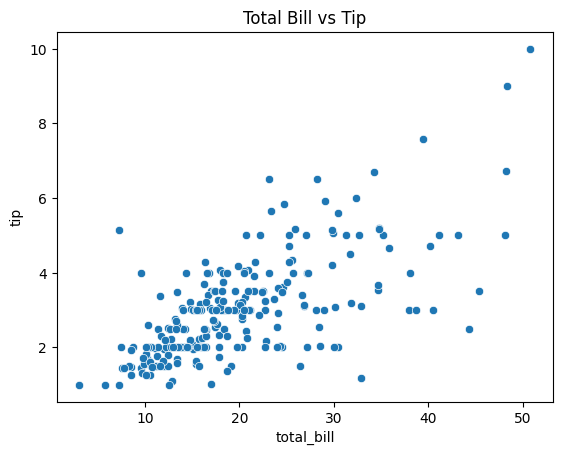

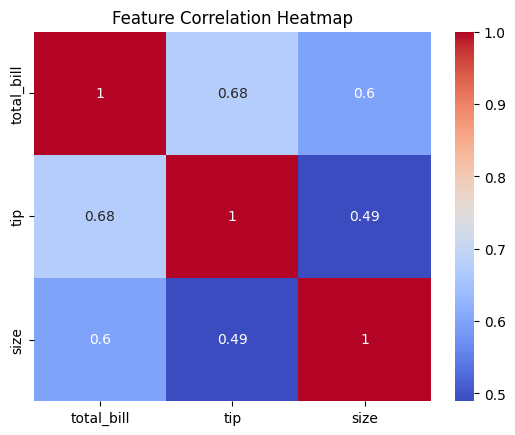

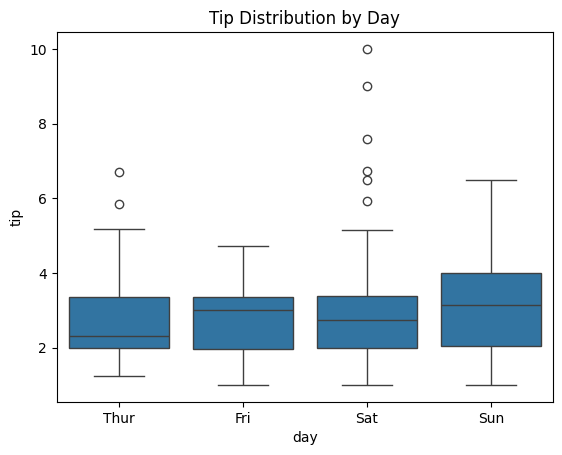

In [9]:
# Visualizations
sns.scatterplot(x='total_bill', y='tip', data=df)
plt.title("Total Bill vs Tip")
plt.show()

# Compute correlation only for numerical columns
numeric_df = df.select_dtypes(include=['number'])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

sns.boxplot(x='day', y='tip', data=df)
plt.title("Tip Distribution by Day")
plt.show()


In [10]:
df.columns

Index(['total_bill', 'tip', 'sex', 'smoker', 'day', 'time', 'size'], dtype='object')

In [11]:
col=['total_bill', 'tip', 'sex', 'smoker', 'day', 'time', 'size']
for i in col:
    if df[i].dtype in ['int','float']:
        q1=df[i].quantile(0.25)
        q3=df[i].quantile(0.75)
        iqr=q3-q1
        lower_bound=q1-1.5*iqr
        upper_bound=q3+1.5*iqr
        df=df[(df[i]>=lower_bound) & (df[i]<=upper_bound)]

In [12]:
df

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
238,35.83,4.67,Female,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


In [13]:
# 3. Data Preparation
# Convert categorical variables using One-Hot Encoding
categorical_features = ['sex', 'smoker', 'day', 'time']
numerical_features = ['total_bill', 'size']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(drop='first'), categorical_features)
])

In [14]:
# Splitting Data
X = df.drop(columns=['tip'])
y = df['tip']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# 4. Base Model Building
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor()
}

base_results = {}

for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    base_results[name] = {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2}
    
    print(f"{name} Performance (Before Tuning):")
    print("MSE:", mse)
    print("RMSE:", rmse)
    print("MAE:", mae)
    print("R² Score:", r2)
    print(f"Predicted Tips for {name} (First 10 values): {y_pred[:10]}")
    print("--------------------------------------------------")



Linear Regression Performance (Before Tuning):
MSE: 0.6571641532471157
RMSE: 0.8106566185797263
MAE: 0.64774414912449
R² Score: 0.38189622067447293
Predicted Tips for Linear Regression (First 10 values): [3.40106978 2.298084   3.12710875 2.85411263 2.2389544  2.82695786
 2.75993354 2.15842652 2.83069275 2.59328615]
--------------------------------------------------
Ridge Regression Performance (Before Tuning):
MSE: 0.6559174049522871
RMSE: 0.809887279164383
MAE: 0.6483941091493717
R² Score: 0.3830688650268673
Predicted Tips for Ridge Regression (First 10 values): [3.3985064  2.30075419 3.12329999 2.84795754 2.23855842 2.82481148
 2.75172827 2.16618633 2.8359555  2.59776242]
--------------------------------------------------
Lasso Regression Performance (Before Tuning):
MSE: 1.1106669824550206
RMSE: 1.0538818636142386
MAE: 0.9045097300690524
R² Score: -0.044651410207667386
Predicted Tips for Lasso Regression (First 10 values): [2.80299435 2.80299435 2.80299435 2.80299435 2.80299435 2.80

In [17]:
# 5. Hyperparameter Tuning
param_grid_ridge = {'model__alpha': [0.1, 1, 10, 100]}
grid_search_ridge = GridSearchCV(Pipeline([
    ('preprocessor', preprocessor),
    ('model', Ridge())
]), param_grid_ridge, cv=5, scoring='r2')

grid_search_ridge.fit(X_train, y_train)
print("Best Parameters for Ridge Regression:", grid_search_ridge.best_params_)

param_grid_lasso = {'model__alpha': [0.1, 1, 10, 100]}
grid_search_lasso = GridSearchCV(Pipeline([
    ('preprocessor', preprocessor),
    ('model', Lasso())
]), param_grid_lasso, cv=5, scoring='r2')

grid_search_lasso.fit(X_train, y_train)
print("Best Parameters for Lasso Regression:", grid_search_lasso.best_params_)

param_grid_tree = {
    'model__max_depth': [3, 5, 10],
    'model__min_samples_split': [2, 5, 10]
}
grid_search_tree = GridSearchCV(Pipeline([
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor())
]), param_grid_tree, cv=5, scoring='r2')

grid_search_tree.fit(X_train, y_train)
print("Best Parameters for Decision Tree:", grid_search_tree.best_params_)

Best Parameters for Ridge Regression: {'model__alpha': 10}
Best Parameters for Lasso Regression: {'model__alpha': 0.1}
Best Parameters for Decision Tree: {'model__max_depth': 3, 'model__min_samples_split': 2}


In [19]:
# 6. Testing & Final Model
final_models = {
    "Ridge Regression": grid_search_ridge.best_estimator_,
    "Lasso Regression": grid_search_lasso.best_estimator_,
    "Decision Tree": grid_search_tree.best_estimator_
}

final_results = {}

for name, model in final_models.items():
    y_pred_final = model.predict(X_test)  # Predicting tips using the best-tuned model
    
    mse = mean_squared_error(y_test, y_pred_final)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred_final)
    r2 = r2_score(y_test, y_pred_final)
    
    final_results[name] = {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2}
    
    print(f"{name} Performance (After Tuning):")
    print("MSE:", mse)
    print("RMSE:", rmse)
    print("MAE:", mae)
    print("R² Score:", r2)
    print(f"Predicted Tips for {name} (First 10 values): {y_pred_final[:10]}")
    print("--------------------------------------------------")



Ridge Regression Performance (After Tuning):
MSE: 0.6511073329058245
RMSE: 0.8069122213139571
MAE: 0.6541273435682736
R² Score: 0.3875930371017684
Predicted Tips for Ridge Regression (First 10 values): [3.3737395  2.32862285 3.08910192 2.81001531 2.24781544 2.80717314
 2.7144434  2.22306669 2.88362416 2.63198958]
--------------------------------------------------
Lasso Regression Performance (After Tuning):
MSE: 0.6971960309860414
RMSE: 0.8349826531048663
MAE: 0.6950347007562889
R² Score: 0.3442437486069303
Predicted Tips for Lasso Regression (First 10 values): [3.23971798 2.38218705 3.02821287 2.60448324 2.24046424 2.9339708
 2.58218168 2.43758125 2.79152858 2.70376115]
--------------------------------------------------
Decision Tree Performance (After Tuning):
MSE: 0.7688551636113615
RMSE: 0.8768438650132425
MAE: 0.6686720206601159
R² Score: 0.27684387525710685
Predicted Tips for Decision Tree (First 10 values): [2.89918367 1.6665625  2.89918367 2.29714286 1.6665625  2.89918367
 2.29

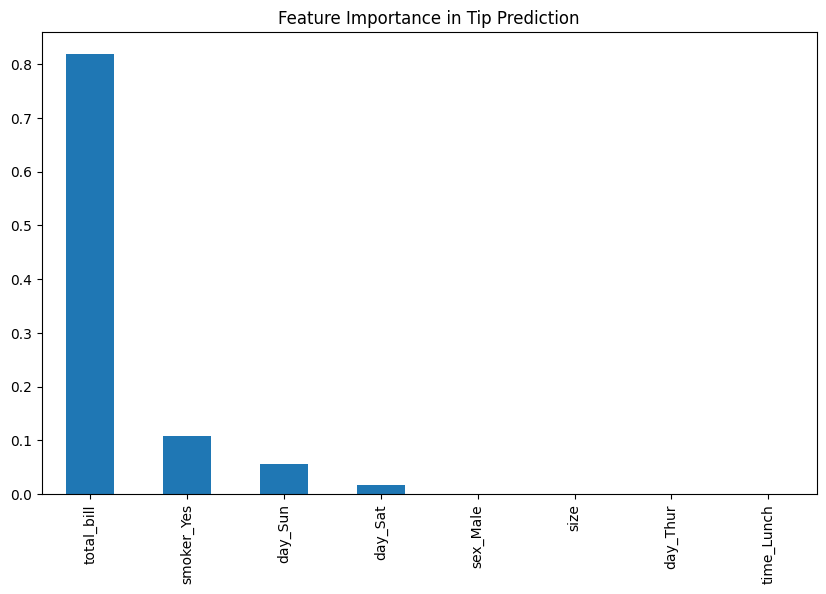

Most important features influencing tip amount:
total_bill    0.818462
smoker_Yes    0.108549
day_Sun       0.056086
day_Sat       0.016903
sex_Male      0.000000
dtype: float64


In [20]:
# Feature Importance (for Decision Tree)
feature_importance = pd.Series(final_models["Decision Tree"].named_steps['model'].feature_importances_, 
                               index=numerical_features + list(final_models["Decision Tree"].named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out()))
feature_importance = feature_importance.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
feature_importance.plot(kind='bar')
plt.title("Feature Importance in Tip Prediction")
plt.show()

print("Most important features influencing tip amount:")
print(feature_importance.head(5))


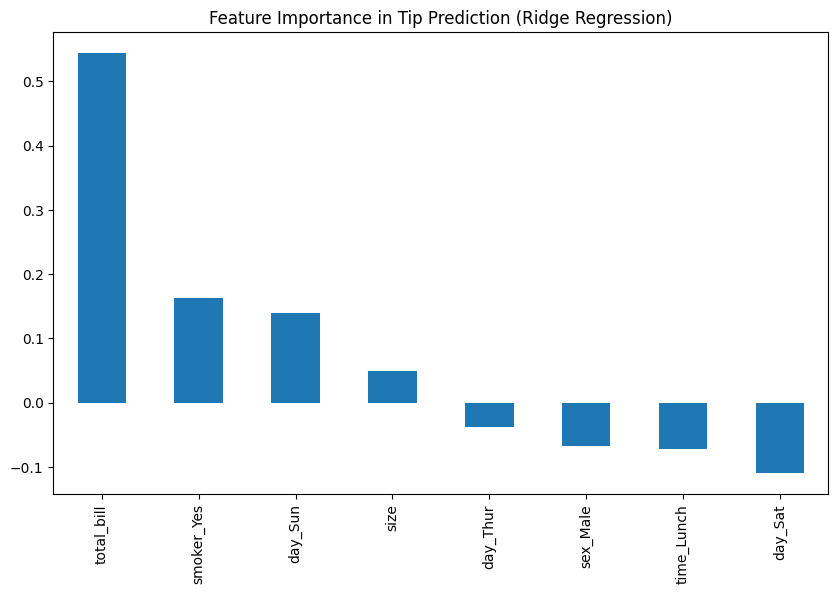

Most important features influencing tip amount (Ridge Regression):
total_bill    0.543982
smoker_Yes    0.163403
day_Sun       0.139473
size          0.048764
day_Thur     -0.038357
dtype: float64


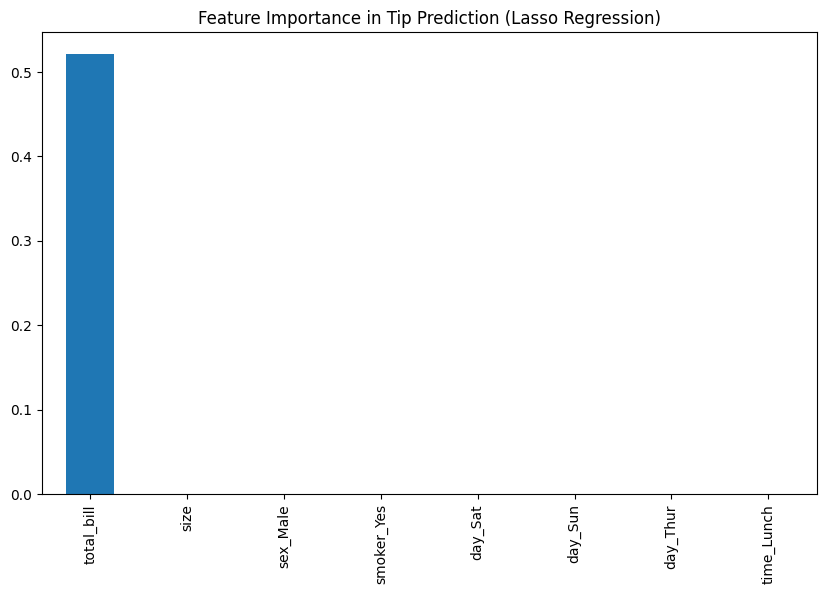

Most important features influencing tip amount (Lasso Regression):
total_bill    0.52092
size          0.00000
sex_Male     -0.00000
smoker_Yes    0.00000
day_Sat      -0.00000
dtype: float64


In [21]:
# Plotting Feature Importance for Linear Regression, Ridge, and Lasso Regression using coefficients
for name in [ "Ridge Regression", "Lasso Regression"]:
    model = final_models[name]
    feature_names = numerical_features + list(model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out())
    coefficients = model.named_steps['model'].coef_
    
    feature_importance = pd.Series(coefficients, index=feature_names).sort_values(ascending=False)
    
    plt.figure(figsize=(10, 6))
    feature_importance.plot(kind='bar')
    plt.title(f"Feature Importance in Tip Prediction ({name})")
    plt.show()
    
    print(f"Most important features influencing tip amount ({name}):")
    print(feature_importance.head(5))